In [1]:
import sys; sys.path.append('..')
from typing import List, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from firelab.utils.fs_utils import load_config

%matplotlib inline

exp_dir = '../../loss-patterns/experiments/random-squares-00003'
logs_export_dir = '../logs_export/random-squares-00003/'

val_acc_diffs = pd.read_csv(f'{logs_export_dir}/val_acc_diffs.csv', index_col=0)
hps = pd.read_csv(f'{logs_export_dir}/hps.csv', index_col=0)
# summaries = [load_config(f'{exp_dir}/summaries/{exp_name}.yml') for exp_name in hps.index.values]
masks = [np.load(f'{exp_dir}/custom_data/{hpo_exp_name}/mask.npy') for hpo_exp_name in hps.index.values]
minima_grid_train = [np.load(f'{exp_dir}/custom_data/{hpo_exp_name}/minima_grid_train.npy') for hpo_exp_name in hps.index.values]
minima_grid_test = [np.load(f'{exp_dir}/custom_data/{hpo_exp_name}/minima_grid_test.npy') for hpo_exp_name in hps.index.values]

In [2]:
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader, Subset
from tqdm import tqdm

from src.models import MaskModel, ConvModel


device = 'cuda:0'


def compute_ensemble_scores(model, ensemble_idx, dataset, mask):
    pos_idx = model.get_class_idx(1)
    dataloader = DataLoader(dataset, batch_size=1024, shuffle=False)
    
    criterion = nn.CrossEntropyLoss(reduction='none')
    losses = []
    guessed = []

    with torch.no_grad():
        for batch in dataloader:
            x = batch[0].to(device)
            y = batch[1].to(device)
            
            preds = [model.run_from_weights(model.compute_point(i,j), x) for i, j in ensemble_idx]
            ensemble_preds = torch.stack(preds).mean(dim=0)
            
            losses.extend(criterion(ensemble_preds, y).cpu().tolist())
            guessed.extend([g for g in (ensemble_preds.argmax(dim=1) == y).cpu().tolist()])

    return np.mean(losses), np.mean(guessed)


def compute_preds(model, i, j, dataloader):    
    w = model.compute_point(i, j)
    preds = []

    with torch.no_grad():
        for x, _ in dataloader:
            x = x.to(device)
            preds.extend(model.run_from_weights(w, x).cpu().tolist())

    return preds


def compute_scores(preds, dataloader):
    losses = []
    criterion = nn.CrossEntropyLoss(reduction='none')
    ys = torch.cat([y.to(device) for _,y in dataloader])
    preds = torch.tensor(preds).to(device)
    
    with torch.no_grad():
        losses = criterion(preds, ys).cpu().tolist()
        guessed = [(p.argmax() == y).item() for p, y in zip(preds, ys)]
            
    return np.mean(losses), np.mean(guessed)


def load_model(hpo_exp_name, mask):
    checkpoint_path = f'{exp_dir}/checkpoints/{hpo_exp_name}/model-11800.pt'
    hp = load_config(f'{exp_dir}/summaries/{hpo_exp_name}.yml').config.hp
    model_builder = lambda: ConvModel(hp.conv_model_config).nn
    model = MaskModel(mask, model_builder, should_center_origin=True, parametrization_type="up_orthogonal")
    model.load_state_dict(torch.load(checkpoint_path))
    model = model.to(device)
    
    return model

In [127]:
from torchvision.datasets import FashionMNIST

train_dataset = FashionMNIST('../data', train=True, transform=transforms.ToTensor())
test_dataset = FashionMNIST('../data', train=False, transform=transforms.ToTensor())

# TODO: use full datasets
train_dataset = Subset(train_dataset, list(range(1000)))
test_dataset = Subset(test_dataset, list(range(1000)))

train_dataloader = DataLoader(train_dataset, batch_size=1024, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

In [4]:
def compute_ensembling_curve(hpo_exp_name:str) -> np.array:
    i = hps.index.tolist().index(hpo_exp_name)
    mask = masks[i]
    model = load_model(hpo_exp_name, mask)
    pos_idx = model.get_class_idx(1)
    
    test_preds = [compute_preds(model, i, j, test_dataloader) for i, j in pos_idx]
    test_scores = [compute_scores(p, test_dataloader) for p in test_preds]
    test_losses, test_accs = zip(*test_scores)
    
    # TODO: will it be the same for accuracy?
    pos_idx = pos_idx[np.argsort(test_losses)]
    ensemble_losses = []
    ensemble_accs = []
    
    for ensemble_size in range(1, len(pos_idx) + 1):
        ensemble_preds = torch.tensor(test_preds[:ensemble_size]).mean(dim=0)
        loss, acc = compute_scores(ensemble_preds, test_dataloader)
        
        ensemble_losses.append(loss)
        ensemble_accs.append(acc)
        
    return ensemble_losses, ensemble_accs

In [128]:
all_losses = []
all_accs = []

for hpo_exp_name in tqdm(hps.index):
    losses, accs = compute_ensembling_curve(hpo_exp_name)
    
    all_losses.append(losses)
    all_accs.append(accs)

100%|██████████| 135/135 [7:49:43<00:00, 248.99s/it]  


In [30]:
def get_model_type_from_config(model_config_str):
    if "'use_bn': True" in model_config_str:
        return 'with_bn'
    elif "'use_skip_connection': True" in model_config_str:
        return 'with_skip_connection'
    else:
        return 'simple'

hps['model_type'] = hps['conv_model_config'].apply(get_model_type_from_config)

In [129]:
losses_dict = {h: l for h, l in  zip(hps.index, all_losses)}
accs_dict = {h: a for h, a in  zip(hps.index, all_accs)}

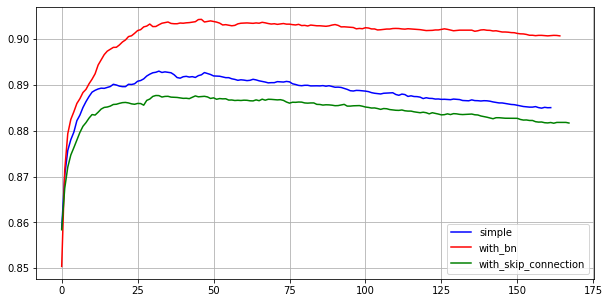

In [156]:
plt.figure(figsize=(10, 5))
    
for model_type, color in [('simple', 'blue'), ('with_bn', 'red'), ('with_skip_connection', 'green')]:
    accs = [accs_dict[hps[hps.model_type == model_type].index[i]] for i in range(hps[hps.model_type == model_type].shape[0])]
    min_len = min(len(a) for a in accs)
    accs = np.array([a[:min_len] for a in accs])

    mean = accs.mean(axis=0)
    std = accs.std(axis=0)

    #plt.fill_between(range(len(mean)), mean + std, mean - std, facecolor=color, alpha=0.1)
    plt.plot(range(len(mean)), mean, color=color, label=model_type)

plt.legend()
plt.grid()